## Question answering with LDA
In this notebook, we attempt to use the trained [LDA topics model](./LDA.ipynb) to find information for the tasks. More specifically, for each task:

1) We define a set of keywords which define the task and treat the task a document consisting of these words.

2) Calculate the topic distribution of the "document" of the task.

3) Find the k abstracts with the most similar topic distributions to the task topic distribution.

In [8]:
import os
import json
import re
from time import time
from collections import Counter

%matplotlib inline

import pickle 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import jensenshannon

### Load LDA model and papers data

In [2]:
print("Loading LDA model...")
lda_dir = os.path.join('data', 'lda_10_topics')
with open(os.path.join(lda_dir, 'model.pkl'), 'rb') as f:
    lda = pickle.load(f)
with open(os.path.join(lda_dir, 'vectorizer.pkl'), 'rb') as f:
    vectorizer = pickle.load(f)
with open(os.path.join(lda_dir, 'count_data.pkl'), 'rb') as f:
    count_data = pickle.load(f)

print("Loading all paper data...")
with open('data/all_text.json', 'r') as f:
    json_data = json.load(f)
    
paper_ids = list(json_data.keys())
index_to_paperid_map = {ind: paper_ids[ind] for ind in range(len(paper_ids))}

paper_topic_dist = lda.transform(count_data) # topic distribution of each paper

assert(len(paper_ids) == paper_topic_dist.shape[0])
paper_topic_dist.shape

Loading LDA model...
Loading all paper data...


(33375, 10)

In [13]:
def top_k_similar(paper_topic_dist: np.ndarray, query_topic_dist: np.ndarray, 
                  metric='euclidean', k=10, return_distances=False, only_covid=False) -> list:
    """
        Input:
            paper_topic_dist - the LDA topic distribution of each paper
            query_topic_dist - the LDA topic distribution of the query
        Returns:
            Indicies of the papers closest in topic distribution to the query
    """
    assert(paper_topic_dist.ndim == 2)
    assert(paper_topic_dist.shape[1] == query_topic_dist.size)
    
    distances = pairwise_distances(paper_topic_dist, query_topic_dist.reshape(1, -1))
    distances = distances.flatten()
    
    assert(distances.shape[0] == paper_topic_dist.shape[0])
    
    indexed_distances = [(i, distances[i]) for i in range(distances.shape[0])]
    
    if only_covid:
        covid_regexp = re.compile(r'covid|cov-19|covid19|corona')
        indexed_distances = [(i, d) for (i,d) in indexed_distances if 
                             covid_regexp.search(json_data[index_to_paperid_map[i]]['abstract'])]
    
    sorted_indexed_distances = sorted(indexed_distances, key=lambda p: p[1])
    ind, d = zip(*sorted_indexed_distances[:k])
    
    if return_distances:
        return ind, d
    else:
        return ind

### Task 1
#### What is known about transmission, incubation, and environmental stability? What do we know about natural history, transmission, and diagnostics for the virus? What have we learned about infection prevention and control?
* Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery.
* Prevalence of asymptomatic shedding and transmission (e.g., particularly children)
* Seasonality of transmission
* Physical science of the coronavirus (e.g., charge distribution, adhesion to hydrophilic/phobic surfaces, environmental survival to inform decontamination efforts for affected areas and provide information about viral shedding).
* Persistence and stability on a multitude of substrates and sources (e.g., nasal discharge, sputum, urine, fecal matter, blood).
* Disease models, including animal models for infection, disease and transmission
* Effectiveness of movement control strategies to prevent secondary transmission in health care and community settings

In [4]:
task1_questions = [
    # general questions
    "What is known about transmission incubation and environmental stability What do we know about natural history transmission and diagnostics for the virus What have we learned about infection prevention and control",
    
    # sub-task questions
    "Range of incubation periods for the disease in humans and how this varies across age and health status and how long individuals are contagious, even after recovery.",
    "Prevalence of asymptomatic shedding and transmission particularly children", 
    "Seasonality season of transmission",
    "Physical science of the coronavirus charge distribution, adhesion to hydrophilic phobic surfaces, environmental survival to inform decontamination efforts for affected areas and provide information about viral shedding",
    "Persistence and stability on a multitude of substrates and sources nasal discharge sputum  urine  fecal matter  blood",
    "Disease models including animal models for infection disease and transmission",
    "Effectiveness of movement control strategies to prevent secondary transmission in health care healthcare and community settings"]

task1_document = '. '.join(task1_questions)
task1_counts = vectorizer.transform([task1_document])[0]
task1_topic_dist = lda.transform(task1_counts.reshape(1, -1))[0]

assert(task1_topic_dist.sum() == 1)
task1_topic_dist

array([0.16119692, 0.00071967, 0.21589232, 0.03001817, 0.01273955,
       0.00071954, 0.02670407, 0.07496354, 0.40285785, 0.07418837])

In [5]:
def display_closest_papers(indices: list, distances: list):
    for ind, d in zip(indices, distances):
        print("------------------------------------------------")
        print(d)
        paper_id = index_to_paperid_map[ind]
        abstract = json_data[paper_id]['abstract']
        title = json_data[paper_id]['title']
        print("Title: ", title)
        print("Abstract: ", abstract)

### Approach 1:  Query for all subtasks of the task jointly
In this experiment, we represent **all subtasks of task 1 as a single document**. We then calculate the topic distribution of this document, and find the papers with the most similar topic distributions.

The results of the experiments are subpar. By examination of each of the top 5 closest papers to the query, we cannot find any direct connection between the paper and any of the individual task 1 subtasks. For instance, the top match is a meta analysis of decision making in medicine. The second and third papers discuss prescription errors in UK hospitals and malaria in China respectively. The 4th paper discusses animals, which is related to one of the tasks, but the context is completely missed; the task asks about infection/disease models on animals, and the paper discusses use of animals to aleviate patient stress.

In [6]:
indices, distances = top_k_similar(paper_topic_dist, task1_topic_dist, 
                                   return_distances=True, k=5, metric=jensenshannon)
display_closest_papers(indices, distances)

------------------------------------------------
0.09256423476375679
Title:  Members of the editorial board
Abstract:  Decision making in medicine is informed by a subtle mixture of factors: education, experience, local protocols, gut feeling, avoiding litigation. The principle of audit is that one can influence practice also by reflecting back personal performance measured against standardised averages or formal guidance. Mitchell and colleagues highlight some of the challenges herein in their analysis of computed tomography in acute presentations with epilepsy. 1 They develop the findings of a recent national audit in the UK in selected cohorts of such patients which identified that as many as one in five patients with known epilepsy had scans following presentation to the emergency department. Many of you reading this are involved with such acute medicine presentations. They present a population level analysis over a 3-year period to identify patient factors associated with the rate

### Same approach, consider only COVID documents
Motivated by the fact that the previous experiment retrieved very generic documents, we decided to repeat the experiment by considering only documents which explicitly talk about COVID-19. The results are slighly more positive. 

For instance, the retrieved paper, "*A high efficient hospital emergency responsive mode is the key of successful treatment of 100 COVID-19 patients in Zhuhai*", discusses the importance of efficient emergancy response in a Chinese city, which is related to the question: "*Effectiveness of movement control strategies to prevent secondary transmission in health care healthcare and community settings*". 

In [14]:
indices, distances = top_k_similar(paper_topic_dist, task1_topic_dist, 
                                   return_distances=True, k=5, 
                                   metric=jensenshannon, only_covid=True)
display_closest_papers(indices, distances)

------------------------------------------------
0.09256423476375679
Title:  Members of the editorial board
Abstract:  Decision making in medicine is informed by a subtle mixture of factors: education, experience, local protocols, gut feeling, avoiding litigation. The principle of audit is that one can influence practice also by reflecting back personal performance measured against standardised averages or formal guidance. Mitchell and colleagues highlight some of the challenges herein in their analysis of computed tomography in acute presentations with epilepsy. 1 They develop the findings of a recent national audit in the UK in selected cohorts of such patients which identified that as many as one in five patients with known epilepsy had scans following presentation to the emergency department. Many of you reading this are involved with such acute medicine presentations. They present a population level analysis over a 3-year period to identify patient factors associated with the rate

Our hyphotesis for the relatively poor performance of this approach, is that the subtasks are **too diverse**. As shown on the plot below, the joint topic distribution of all subtasks has 3 topics with a relatively high probability. Because of this, the matched papers are also generic and span **multiple topics**.

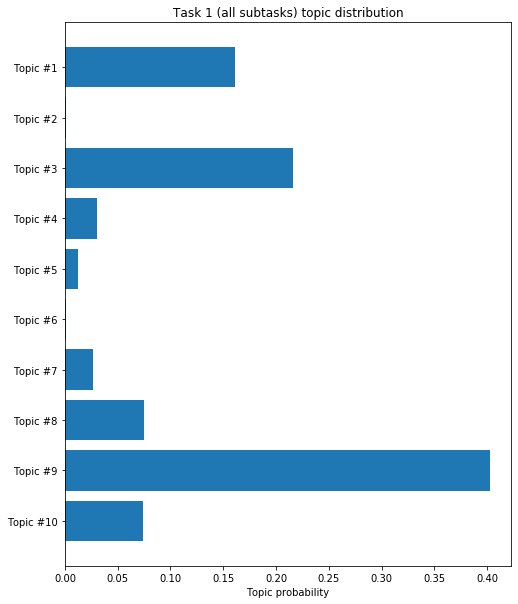

In [15]:
def plot_topic_dist(topic_dist: np.ndarray, title='Topic distribution'):
    n_topics = topic_dist.shape[0]
    
    fig, ax = plt.subplots()
    fig.set_figheight(10)
    fig.set_figwidth(8)
    ax.barh(np.arange(n_topics), topic_dist, align='center')
    ax.set_yticks(np.arange(n_topics))
    ax.set_yticklabels(["Topic #{}".format(i + 1) for i in range(n_topics)])
    ax.invert_yaxis()  # labels read top-to-bottom

    ax.set_xlabel('Topic probability')
    ax.set_title(title)
    plt.show()

plot_topic_dist(task1_topic_dist, title='Task 1 (all subtasks) topic distribution')

### Task 1: Querying subtasks separately
This method obtains much more relevant results. 
#### Subtask: Prevalence of asymptomatic shedding and transmission particularly children.
All of the retrieved papers discuss transmittion of the coronavirus, although we couldn't find a focus on asymptomatic transmission specifically. "*Seroepidemiology of Human Bocavirus Infection in Jamaica*" discussed transmission among children in particular.

In [11]:
question = "Prevalence of asymptomatic shedding and transmission particularly children."
question_counts = vectorizer.transform([question])[0]
question_topic_dist = lda.transform(question_counts.reshape(1, -1))[0]
question_topic_dist

array([0.0111145 , 0.71456275, 0.01111416, 0.01111266, 0.01111225,
       0.01111195, 0.01111239, 0.01111523, 0.196532  , 0.01111212])

In [12]:
indices, distances = top_k_similar(paper_topic_dist, question_topic_dist, 
                                   return_distances=True, k=5, metric=jensenshannon)
display_closest_papers(indices, distances)

------------------------------------------------
0.056111108224192394
Title:  Environmental investigation of respiratory pathogens during the Hajj 2016 and 2018
Abstract:  Background: Respiratory tract infections are common in the context of the Hajj pilgrimage and respiratory pathogens can be transmitted via contact with contaminated surfaces. We sampled surfaces during the Hajj to detect the presence of respiratory bacteria and viruses. Methods: Frequently touched surfaces at Mecca, Mina, Arafat and Medina were sampled. The common respiratory pathogens were tested by qPCR. Results: 70/142 (49.3%) environmental samples collected were positive for at least one respiratory pathogen. Among the positive samples, Klebsiella pneumoniae was the bacterium most frequently tested positive (57.1%), followed by Streptococcus pneumoniae (12.9%), Staphylococcus aureus (10.0%) and Haemophilus influenzae (7.1%). 32.9% positive samples tested positive for rhinovirus and 1.4% for coronavirus. Surfaces 

#### Subtask: Disease models including animal models for infection disease and transmission
According to us, the most relevant responses so far. All of the paper matches discuss spreading of COVID-related viruses, and the majority of them use animal models.

In [19]:
question = "Disease models including animal models for infection disease and transmission."
question_counts = vectorizer.transform([question])[0]
question_topic_dist = lda.transform(question_counts.reshape(1, -1))[0]
question_topic_dist

array([0.00909392, 0.00909167, 0.00909434, 0.00909145, 0.009093  ,
       0.00909176, 0.00909166, 0.51034465, 0.41691448, 0.00909305])

In [20]:
indices, distances = top_k_similar(paper_topic_dist, question_topic_dist, 
                                   return_distances=True, k=5, metric=jensenshannon)
display_closest_papers(indices, distances)

------------------------------------------------
0.043891657144334455
Title:  Public health concerns of highly pathogenic avian influenza H5N1 endemicity in Africa
Abstract:  Highly pathogenic avian influenza virus (HPAIV) H5N1 was first officially reported in Africa in 2006; thereafter this virus has spread rapidly from Nigeria to 11 other African countries. This study was aimed at utilizing data from confirmed laboratory reports to carry out a qualitative evaluation of the factors responsible for HPAI H5N1 persistence in Africa and the public health implications; and to suggest appropriate control measures. Relevant publications were sought from data banks and repositories of FAO, OIE, WHO, and Google scholars. Substantiated data on HPAI H5N1 outbreaks in poultry in Africa and in humans across the world were mined. HPAI H5N1 affects poultry and human populations, with Egypt having highest human cases (346) globally. Nigeria had a reinfection from 2014 to 2015, with outbreaks in Côte 

#### Subtask: Physical science of the coronavirus charge distribution, adhesion to hydrophilic phobic surfaces, environmental survival to inform decontamination efforts for affected areas and provide information about viral shedding

In [16]:
question = "Physical science of the coronavirus charge distribution adhesion to hydrophilic phobic surfaces environmental survival to inform decontamination efforts for affected areas and provide information about viral shedding"
question_counts = vectorizer.transform([question])[0]
question_topic_dist = lda.transform(question_counts.reshape(1, -1))[0]
question_topic_dist

array([0.00370517, 0.00370454, 0.00370539, 0.16769765, 0.05836264,
       0.00370461, 0.14157344, 0.15422247, 0.45961822, 0.00370586])

In [17]:
indices, distances = top_k_similar(paper_topic_dist, question_topic_dist, 
                                   return_distances=True, k=5, metric=jensenshannon)
display_closest_papers(indices, distances)

------------------------------------------------
0.16222901804263626
Title:  Physica A Coupled effects of local movement and global interaction on contagion
Abstract:  • Segregated spatial domain and individual-based linkage are incorporated into SIS model. • Activating a small number of individual-based linkage between different spatial domains can prompt the outbreak of epidemic globally. • Narrowing segregated spatial domain and reducing mobility are conducive to suppression of infectious disease. a b s t r a c t By incorporating segregated spatial domain and individual-based linkage into the SIS (susceptible-infected-susceptible) model, we propose a generalized epidemic model which can change from the territorial epidemic model to the networked epidemic model. The role of the individual-based linkage between different spatial domains is investigated. As we adjust the timescale parameter τ from 0 to unity, which represents the degree of activation of the individual-based linkage, th